# 2025 DL Lab7: Image Generation

**Your Answer:**    
Hi I'm 邱照元, 314834001.

## Overview
This assignment focuses on implementing a deep generative model to synthesize high-quality floral images using the **Oxford Flowers102 dataset**. 

The objective is to train the model to capture fine-grained features and complex textures inherent in the data distribution. 

To quantitatively measure the performance, the **Fréchet Inception Distance (FID)** is employed as the primary metric, assessing both the fidelity and diversity of the generated samples against the real training data.

## Unzip resized_flowers102.zip

This file contains the Flowers102 dataset cropped to a 64x64 resolution, intended for the final FID score calculation. 

It comprises a total of **8,189** images.

可以使用其他的模型，不只是 GAN
Kaggle: 分數可以在本地計算，不用上傳才看的到

In [26]:
#%matplotlib inline
import random
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim 
import torch.utils.data
import torchvision.utils as vutils
import torch
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms as T
import torchvision
import matplotlib.pyplot as plt

# Set random seed for reproducibility
manualSeed = 0
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Random Seed:  0


In [27]:
# Number of workers for dataloader
workers = 8

# Batch size during training
batch_size = 256

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 128

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 500

# Learning rate for optimizers
lr = 0.0001

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Number of times to update the critic before updating the generator
n_critic = 8

# Weight clipping range
clip_value = 0.01

In [28]:
from torch.utils.data import ConcatDataset

##########################################################################
# TODO: Define the data transformation pipeline.                         #
# You need to implement a Compose pipeline that includes:                #
# 1. Resizing images to the target size(64*64).                          #
# 2. Applying data augmentation techniques to increase dataset diversity #
# 3. Converting images to Tensor.                                        #
# 4. Normalizing the pixel values to the range [-1, 1].                  #
##########################################################################

transform = transforms.Compose([
    # Your Code Here
    T.Resize((image_size, image_size)),
    # T.RandAugment(),
    T.ColorJitter(0.2, (0.9,1.3), (0.8,1.5), 0.05),
    T.RandomHorizontalFlip(0.5),
    
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

##########################################################################
#                            End of your code                            #
##########################################################################


trainset = torchvision.datasets.Flowers102(root='./data', split='test', transform=transform, download=True)
testset = torchvision.datasets.Flowers102(root='./data', split='train', transform=transform, download=True)
validdataset = torchvision.datasets.Flowers102(root='./data', split='val', transform=transform, download=True)
dataset = ConcatDataset([trainset, testset, validdataset])

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

print("訓練集樣本數量:", len(dataset))

訓練集樣本數量: 8189


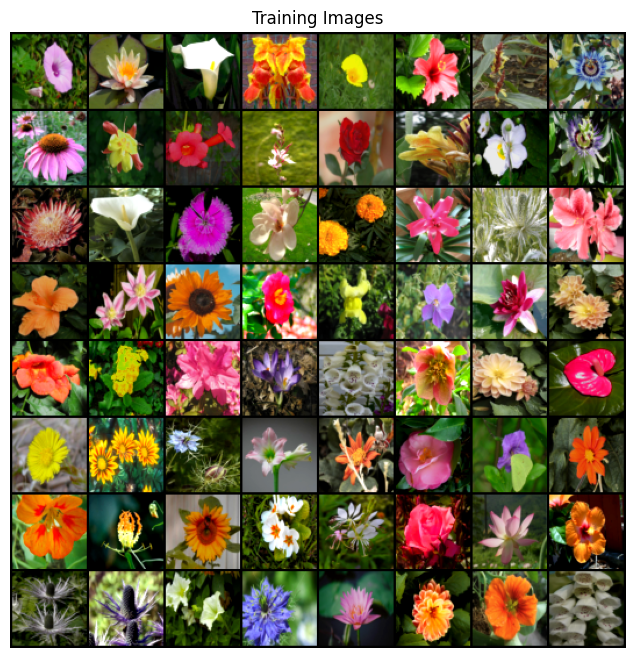

In [29]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Initialize parameters of Generator and Discriminator
This step for initializing the parameters of the generator and discriminator.
And define the structure of the dcGAN.

$$PV=nRT$$

In [30]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [31]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is Z (latent vector), going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            #############################################################################
            # TODO: Implement the Upsampling Blocks.                                    #
            # You need to progressively increase the spatial size of the feature maps   #
            # while decreasing the number of channels.                                  #
            # The goal is to reach a feature map size compatible with the final output. #
            #############################################################################
            # state size. (ngf*8) x 4 x 4 -> (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8 -> (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16 -> (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            #############################################################################
            #                             End of your code                              #
            #############################################################################

            # Final output layer
            # State size: (ngf) x 32 x 32 -> (nc) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [32]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            #############################################################################
            # TODO: Implement the Downsampling Blocks.                                  #
            # You need to progressively decrease the spatial size of the feature maps   #
            # while increasing the number of channels to extract features.              #
            #############################################################################
            # state size. (ndf) x 32 x 32 -> (ndf*2) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*2) x 16 x 16 -> (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*4) x 8 x 8 -> (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            #############################################################################
            #                             End of your code                              #
            #############################################################################

            # Final classification layer
            # State size: (ndf*8) x 4 x 4 -> 1
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [33]:
# Create the generator
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)
print(netG)


# Create the Discriminator
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [34]:
# Fixed noise vector for observing generator's progression
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Optimizers use RMSProp, not Adam
optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

## Training Step

In [35]:
def update_critic(netD, netG, optimizerD, real_data, noise, clip_value=0.01):
    """
    更新 Critic (Discriminator)
    Loss Formula: minimize -(E[D(x)] - E[D(G(z))])
    也就是: minimize -mean(D(real)) + mean(D(fake))
    """
    netD.zero_grad()
    
    # 1. Real Data Loss (Maximize D(x) -> Minimize -D(x))
    output_real = netD(real_data).view(-1)
    loss_real = -torch.mean(output_real)
    loss_real.backward()
    
    # 2. Fake Data Loss (Minimize D(G(z)))
    fake_data = netG(noise)
    # 注意: 這裡要 detach，避免梯度傳回 Generator
    output_fake = netD(fake_data.detach()).view(-1)
    loss_fake = torch.mean(output_fake)
    loss_fake.backward()
    
    # Update weights
    optimizerD.step()
    
    # 3. Weight Clipping (WGAN 獨有特徵)
    # 強制權重在 [-c, c] 之間以滿足 Lipschitz constraint
    for p in netD.parameters():
        p.data.clamp_(-clip_value, clip_value)
        
    # 回傳總 Loss 供紀錄
    return loss_real + loss_fake

def update_generator(netD, netG, optimizerG, noise):
    """
    更新 Generator
    Loss Formula: maximize D(G(z)) -> minimize -D(G(z))
    """
    netG.zero_grad()
    
    fake_data = netG(noise)
    # Generator 更新時，需要梯度穿過 D，所以不需要 detach
    output = netD(fake_data).view(-1)
    
    # Generator 希望 Critic 認為這是真的 (分數越高越好)
    loss_g = -torch.mean(output)
    loss_g.backward()
    
    optimizerG.step()
    
    return loss_g

In [36]:
# Training Loop
import torchvision.transforms as T
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
clip_value = 0.01
# masked_real_cpu = add_random_mask(real_cpu.clone())
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        # 準備資料
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        
        ############################
        # (1) Update Critic (Discriminator)
        ###########################
        for p in netD.parameters():
            p.requires_grad = True

        ##################################################################################
        # TODO: Implement the Critic (Discriminator) Update Loop.                        #
        # 1. Clear gradients.                                                            #
        # 2. Compute the loss for real images (maximize D(x)).                           #
        # 3. Compute the loss for fake images (minimize D(G(z))).                        #
        # 4. Compute total Critic loss (Wasserstein distance approximation).             #
        # 5. Backpropagate and update Critic weights.                                    #
        # 6. Apply Weight Clipping to ensure Lipschitz constraint.                       #
        ##################################################################################
        # Your Code Here (Loop structure and logic)
        errD = update_critic(netD, netG, optimizerD, real_cpu, noise, clip_value)

        ##################################################################################
        #                                 End of your code                               #
        ##################################################################################


        ############################
        # (2) Update Generator
        ###########################
        for p in netD.parameters():
            p.requires_grad = False

        netG.zero_grad()
        
        ##################################################################################
        # TODO: Implement the Generator Update Logic.                                    #
        # 1. Generate fake images from noise.                                            #
        # 2. Compute the Generator loss.                                                 #
        #    (The Generator wants to maximize D(G(z)), which means minimizing -D(G(z))). #
        # 3. Backpropagate and update Generator weights.                                 #
        ##################################################################################
        # Your Code Here
        errG = update_generator(netD, netG, optimizerG, noise)

        ##################################################################################
        #                                 End of your code                               #
        ##################################################################################


        # Output training status
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item()))

        # Save loss values for later plotting
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check generator's performance periodically
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/500][0/32]	Loss_D: 0.0537	Loss_G: -0.4938
[1/500][0/32]	Loss_D: -0.0009	Loss_G: -0.5007
[2/500][0/32]	Loss_D: -0.0030	Loss_G: -0.5010
[3/500][0/32]	Loss_D: -0.0005	Loss_G: -0.5017
[4/500][0/32]	Loss_D: -0.0029	Loss_G: -0.5013
[5/500][0/32]	Loss_D: -0.0022	Loss_G: -0.5030
[6/500][0/32]	Loss_D: -0.0028	Loss_G: -0.5011
[7/500][0/32]	Loss_D: -0.0030	Loss_G: -0.4983
[8/500][0/32]	Loss_D: -0.0025	Loss_G: -0.5002
[9/500][0/32]	Loss_D: -0.0030	Loss_G: -0.4979
[10/500][0/32]	Loss_D: -0.0056	Loss_G: -0.4930
[11/500][0/32]	Loss_D: -0.0063	Loss_G: -0.4845
[12/500][0/32]	Loss_D: -0.0099	Loss_G: -0.4841
[13/500][0/32]	Loss_D: -0.0065	Loss_G: -0.4692
[14/500][0/32]	Loss_D: -0.0159	Loss_G: -0.4579
[15/500][0/32]	Loss_D: -0.0250	Loss_G: -0.4479
[16/500][0/32]	Loss_D: -0.0115	Loss_G: -0.4512
[17/500][0/32]	Loss_D: -0.0531	Loss_G: -0.4746
[18/500][0/32]	Loss_D: -0.0664	Loss_G: -0.4591
[19/500][0/32]	Loss_D: -0.0194	Loss_G: -0.4748
[20/500][0/32]	Loss_D: -0.0243	Loss_G: -0.433

In [37]:
weights_dir = './model_weight/'
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

torch.save(netG.state_dict(), os.path.join(weights_dir, 'Generator_weights.pth'))
torch.save(netD.state_dict(), os.path.join(weights_dir, 'Discriminator_weights.pth'))

print("model weight save to 'model_weight/'")

model weight save to 'model_weight/'


## Create fake dataset for calculating FID scores
FID scores use to evaluate the similarity between two datasets.

In [38]:
# Generate new images and save them
noise = torch.randn(8189, nz, 1, 1, device=device)

netG.eval()
with torch.no_grad():
    fake = netG(noise)


output_dir = './GENIMG/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for j in range(fake.size(0)):
    transform = T.Compose([T.Normalize(mean=[-1, -1, -1], std=[2, 2, 2]), T.ToPILImage()])
    img = transform(fake[j].cpu())
    img.save('./GENIMG/fake' + str(j) + '.jpg')

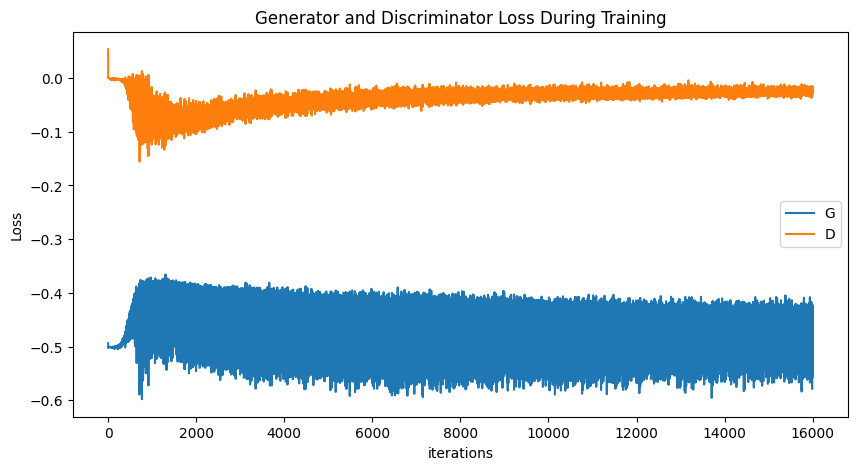

In [39]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [40]:
# Calculate FID
import torch
import torchvision
import torchvision.transforms as transforms
from pytorch_fid import fid_score
from PIL import Image
import os

# Resized original dataset path after 64x64 pixel adjustment
resized_folder_path = './resized_flowers102/'
# Generated image folder
generated_images_folder = './GENIMG/'
# Use Inception V3 model to calculate FID
inception_model = torchvision.models.inception_v3(pretrained=True)
fid_value = fid_score.calculate_fid_given_paths([resized_folder_path, generated_images_folder], batch_size=batch_size, device=device, dims=2048, num_workers=8)
print('FID value:', fid_value)

/home/m314834001/Lab7/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/m314834001/Lab7/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID value: 61.8897442959485


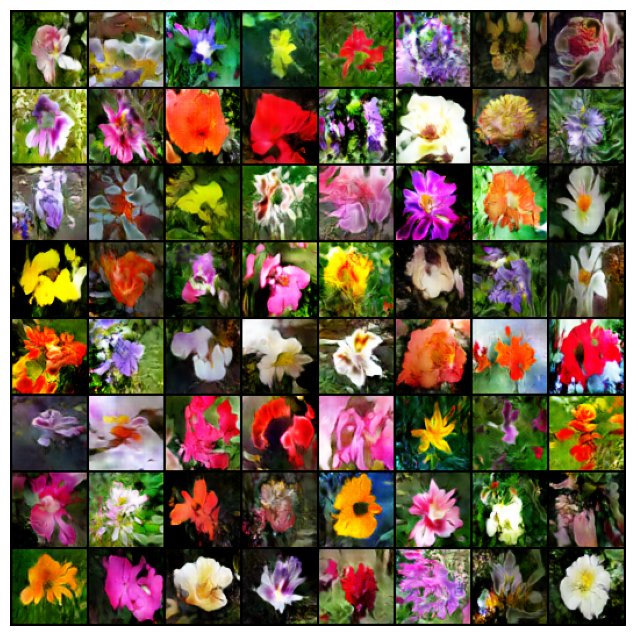

In [41]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]

## Predict Result

In [42]:
import pandas as pd

df_submission = pd.DataFrame({
    'id': [1], 
    'fid_score': [fid_value]
})

output_csv_path = 'result.csv'
df_submission.to_csv(output_csv_path, index=False)